In [ ]:
!ls data/

In [ ]:
!mkdir utils

In [ ]:
!git clone https://gist.github.com/17e5275bf5bbdf81e89e93241ad93ce5.git utils/

In [ ]:
!ls utils/

# Load packs

In [395]:
import pandas as pd
import numpy as np
from utils import dataset as fn
import json
import glob
from dateutil.parser import parse
import itertools
import gc
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 150)

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [143]:
def cnt_groups(data: pd.DataFrame,
               gr: list,
               colname: str
              ) -> pd.DataFrame:
    
    tmp=data.groupby(gr).size().reset_index().rename(columns={0: colname})                                         
    df=data.reset_index().merge(tmp, how='left', on=gr).fillna(-1)
    return (df.set_index("Time"))

def make_stats_features(df: pd.DataFrame,
                        group_col: list,
                        used_col: str,
                        prefix: str
                       ) -> pd.DataFrame:
    """
    Count stats: mean, std
    """
    tmp = df.groupby(group_col)[used_col].agg({np.mean, np.std}).fillna(0)
    tmp.columns = [prefix +'_'+ str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    tmp = tmp[tmp.columns[tmp.nunique()>1]]
    df = df.reset_index().merge(tmp, on=group_col, how="left")
    return (df.set_index("Time"))

def make_harmonic_features(df: pd.DataFrame,
                           column: list
                          ) -> pd.DataFrame:
    """
    For periodic feats
    """
    
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value, dtype='float32')
        df[col + '_sin'] = np.sin(value, dtype='float32')
    return (df)


def plot_kde(df: pd.DataFrame,
             var: str,
             target: str = "Target",
             **kwargs: str
            ) -> plt:
    
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (df[var].min(), df[var].max()))
    facet.add_legend()
    plt.show()
    
    
def plot_target_distribution(df: pd.DataFrame,
                             cols_to_drop: list,
                             target: str,
                             title: str,
                             color_0: str = '#770000',
                             color_1: str = '#007700'
                            ) -> plt:
    
    cols=list(filter(lambda x: x not in cols_to_drop, df.columns))
    plt.figure(figsize=[18,8])
    for i, col in enumerate(cols):
        n_unique = df[col].nunique()
        cl = 3
        rw = np.ceil(df.shape[1] / cl).astype(int)
        ax = plt.subplot(rw, cl, i+1)
        bins_cnt = 30 if n_unique>30 else n_unique
        df.loc[df['Target']==0][col].hist(color=color_0, bins=bins_cnt , alpha=.5)
        df.loc[df['Target']==1][col].hist(color=color_1, bins=bins_cnt, alpha=.5)
        ax.set_title(f"{str(col)}, n_unique: {n_unique}", fontsize=15)
        ax.set_yscale('log')
        ax.legend(['0', '1'])

    plt.suptitle(title, y=1.05, fontsize=20)    
    plt.tight_layout();

In [3]:
# use_col = lambda col: col not in ["Id"]
PATH_TO_DATA = Path('data')
df = pd.read_csv("data/train.csv", index_col="Time", parse_dates=True)
dft = pd.read_csv("data/test.csv", index_col="Time", parse_dates=True)

df.sort_index(inplace=True)
dft.sort_index(inplace=True)

# add official holidays in Russia
    # Source: https://github.com/d10xa/holidays-calendar
fl_json = glob.glob("data/consultant*.json")

holidays_list = []
for fl  in sorted(fl_json):
    with open(fl) as f:
        d = json.load(f)
        holidays_list.append(d)

parse_date = lambda x: parse(x).date()
train_holidays = list(map(parse_date, 
                        # combine dates of 2017 and 2018 ys
                        list( itertools.chain(*[days['holidays'] for days in holidays_list[:-1]]) ) ))

test_holidays = list( map(parse_date, holidays_list[-1]['holidays']) )

train_holidays_bins = lambda x: 1 if x in train_holidays else 0
df['is_holiday'] = df.index.map(train_holidays_bins)

test_holidays_bins = lambda x: 1 if x in test_holidays else 0
dft['is_holiday'] = dft.index.map(test_holidays_bins)

df = fn.reduce_mem_usage(df)
dft = fn.reduce_mem_usage(dft)

Mem. usage decreased to 17.35 Mb (45.9% reduction)
Mem. usage decreased to  2.26 Mb (44.4% reduction)


In [4]:
df.head()

,Id,ClientID,ClientType,CoachID,GymID,TrainingID,Target,is_holiday
Time,,,,,,,,
2017-01-01 08:00:00,113828,10962,2,495,1,847,1,1
2017-01-01 08:00:00,46246,63159,2,71,0,840,1,1
2017-01-01 08:00:00,43829,60091,1,523,0,1564,1,1
2017-01-01 08:00:00,24306,33441,2,270,3,840,1,1
2017-01-01 08:15:00,89407,114152,2,440,1,726,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321167 entries, 2017-01-01 08:00:00 to 2018-12-30 15:30:00
Data columns (total 8 columns):
Id            321167 non-null int32
ClientID      321167 non-null int32
ClientType    321167 non-null int8
CoachID       321167 non-null int16
GymID         321167 non-null int8
TrainingID    321167 non-null int16
Target        321167 non-null int8
is_holiday    321167 non-null int8
dtypes: int16(2), int32(2), int8(4)
memory usage: 17.4 MB


In [ ]:
print("Target distribution:")
print(df.Target.value_counts(normalize=True))
sns.countplot(df.Target);

In [ ]:
df.nunique()

In [ ]:
df.isna().sum().sum(), dft.isna().sum().sum()

In [ ]:
dft.nunique()

In [ ]:
df.shape, dft.shape

In [ ]:
plot_target_distribution(df, cols_to_drop=["Target", "Id"], target="Target", title='Log target distribution (train)')

In [ ]:
plot_kde(df, "TrainingID")

In [149]:
# th = len(df)
target = df.Target
df_all = pd.concat([df.loc[:, dft.columns], dft])
df_all.shape

((367426, 7), 321167)

In [ ]:
plt.figure(figsize=[18,8])
for i, col in enumerate(df_all.columns):
    nun_tr = df[col].nunique()
    nun_test = dft[col].nunique()
    cl = 3
    rw = np.ceil(df_all.shape[1] / cl).astype(int)
    ax = plt.subplot(rw, cl, i+1)
    df[col].hist(alpha=.5)
    dft[col].hist(alpha=.5)
    ax.set_title(f"{str(col)}, nun_tr: {nun_tr}, nun_test: {nun_test}", fontsize=15)
    ax.set_yscale('log')
    ax.legend(['train', 'test'])

plt.suptitle('Log feats distribution (train/test)', 
             y=1.05,  fontsize=20)    
plt.tight_layout();

In [171]:
dft_copy['tar'] = 999

In [172]:
dft_copy

,Id,ClientID,ClientType,CoachID,GymID,TrainingID,is_holiday,tar
Time,,,,,,,,
2019-01-01 08:00:00,31573,10514,1,135,0,808,1,999
2019-01-01 08:00:00,45300,4727,1,220,4,954,1,999
2019-01-01 08:00:00,24602,91745,1,456,4,1454,1,999
2019-01-01 08:00:00,12341,101223,1,440,1,726,1,999
2019-01-01 08:00:00,26554,65917,1,534,0,711,1,999
...,...,...,...,...,...,...,...,...
2019-09-27 09:00:00,29355,139400,1,792,6,2070,0,999
2019-09-27 10:00:00,29356,139400,1,792,6,80,0,999
2019-09-29 12:00:00,29364,139400,1,770,6,1606,1,999


In [315]:
def gen_feats(train, test):
    
    test["Target"] = 999
    df = pd.concat([train, test]).copy()
    
    # simple datetime feats ===========
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["week"] = df.index.week
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    
    # numeric feats related with grouping ClientID =======
    df["cnt_visits"] = df["ClientID"].map( df["ClientID"].value_counts() )
    df["cnt_gyms_per_client"] = df["ClientID"].map( df.groupby("ClientID")["GymID"].nunique() )
    df["cnt_coach_per_client"] = df["ClientID"].map( df.groupby("ClientID")["CoachID"].nunique() )
    df["cnt_traintype_per_client"] = df["ClientID"].map( df.groupby("ClientID")["TrainingID"].nunique() )
       
    # order_of_visits, invert_order_of_visits, pct_order =======
    tmp = df.reset_index()[['Time', 'ClientID']].copy()

    tmp = tmp.sort_values(by=["ClientID", "Time"])
    tmp['range'] = np.arange(len(tmp))
    tmp2 = tmp.ClientID.map(tmp.groupby("ClientID").range.min()).values
    tmp3 = (tmp.ClientID.map(tmp.groupby("ClientID").range.max()) - tmp2 + 1).values

    tmp["order_of_visits"] = tmp['range'] - tmp2
    tmp["invert_order_of_visits"] = tmp3 - tmp["order_of_visits"].values
    tmp["pct_order"] = tmp.order_of_visits / tmp.ClientID.map(tmp.groupby("ClientID").range.max())
    
    new_cols = ["order_of_visits", "invert_order_of_visits", "pct_order"]
    df = pd.concat([df.reset_index().sort_values(by=["Time", "ClientID"]), 
                   tmp.drop('range', axis=1).sort_values(by=["Time", "ClientID"])[new_cols]], axis=1).set_index("Time")
        
    # days_before_last_train ========
    tmp = df.reset_index().sort_values(by=["ClientID", "Time"])[["ClientID", "Time"]].copy()
    gr = tmp.groupby("ClientID")

    diff_days_fn = lambda x: np.round(x.diff().fillna(pd.Timedelta(seconds=0)) / np.timedelta64(1,'D'))
    new_cols = ["cnt_days_before_last_train"]
    tmp[new_cols] = gr.pipe(diff_days_fn)
    df = pd.concat([df.reset_index().sort_values(by=["Time", "ClientID"]), 
                    tmp.sort_values(by=["Time", "ClientID"])[new_cols]], axis=1).set_index("Time")

    del tmp, tmp2, tmp3
    gc.collect()
       
    # ===============
    df["date"] = df.index.to_period("D")
    df = cnt_groups(df, ["ClientID", "date"], "cnt_train_per_day")
       
    #  ==============
    df["time"] = df.index.strftime("%H:%M:%S")
    df = cnt_groups(df, ["time", "GymID"], "cnt_groups_gymID_time")
    df["time_value_cnt"] = df.time.map(df.time.value_counts())
    
    df["cnt_ClientType_per_coach"] = df.CoachID.map(df.groupby("CoachID")["ClientType"].nunique())
    df["cnt_coaches_per_gym"] = df.GymID.map(df.groupby("GymID")["CoachID"].nunique())
    df["cnt_clients_per_gym"] = df.GymID.map(df.groupby("GymID")["ClientID"].nunique())
    
    # weekly average and std of client's training =====
    df['year'] = df.index.year
    df = make_stats_features(df, group_col=['ClientID', 'year', 'week'], used_col='cnt_train_per_day', prefix='client_weektrain')
    
    df = fn.reduce_mem_usage(df)
    
    # train/test split df_all ======
    train_df = df['2017':'2018']
    test_df = df['2019']
    print("Train shape: ", train_df.shape)
    print("Test shape: ", test_df.shape)
    
    return train_df, test_df.drop("Target", axis=1)

In [316]:
%%time
train_df, test_df = gen_feats(df, dft)

Mem. usage decreased to 34.34 Mb (56.1% reduction)
Train shape:  (321167, 32)
Test shape:  (46259, 32)
CPU times: user 16.6 s, sys: 170 ms, total: 16.8 s
Wall time: 15.7 s


In [317]:
# save data as pkl

with open(PATH_TO_DATA/'raw_train_df.pkl', 'wb') as fout:
    pickle.dump(train_df, fout, protocol=2)
    
with open(PATH_TO_DATA/'raw_test_df.pkl', 'wb') as fout:
    pickle.dump(test_df, fout, protocol=2)

# Out-of-the-box models

In [644]:
from IPython.display import display_html
from contextlib import contextmanager
import time
from scipy.special import boxcox1p

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     ShuffleSplit, StratifiedKFold, TimeSeriesSplit)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_metric
import xgboost as xgb


In [664]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
    
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    

def tree_based_model_compare(X, y, cv, seed, score='roc_auc'):
    
    model_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                max_depth=None, random_state=seed)
    model_lgb = LGBMClassifier(random_state=seed)
    model_xgb = xgb.XGBClassifier(random_state=seed)
    model_cat = CatBoostClassifier(random_state=seed, silent=True)
 
    with timer('RandomForestClassifier...'):
        cv_scores_rf = cross_val_score(model_rf, X, y, cv=cv, scoring=score)

    with timer('LGBMClassifier...'): 
        cv_scores_lgb = cross_val_score(model_lgb, X, y, cv=cv, scoring=score, n_jobs=-1)
        
    with timer('XGBClassifier...'):
        cv_scores_xgb = cross_val_score(model_xgb, X, y, cv=cv, scoring=score, n_jobs=-1)
    
    with timer('CatBoostClassifier...'):
        cv_scores_cat = cross_val_score(model_cat, X, y, cv=cv, scoring=score, n_jobs=-1)
    
    cv_results = pd.DataFrame(data={'RF': cv_scores_rf, 
                                    'LGB':cv_scores_lgb, 
                                    'XGB':cv_scores_xgb, 
                                    'CAT':cv_scores_cat})
    
    return display_side_by_side(cv_results, cv_results.describe())

def create_partial_df_all(train, cols, test):
    used_cols = [col for col in raw_test_df.columns if col in cols]
    df_all = pd.concat([ train[used_cols],
                         test[used_cols] ])
    return (df_all.reset_index(drop=True))

def diagnostic_plots(df, variable):
    # func to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.suptitle(variable)
    plt.show()
    
def box_cox_transform(data, num_col=None):
    """
    Box Cox Transformation of (highly: > 0.75) skewed features
    """
    if not num_col:
        num_col = data.columns
    df = data.copy()
    skewed_feats = df[num_col].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    
    skewness = pd.DataFrame({'Skew': skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print(f"There are {skewness.shape[0]} skewed numerical features to Box Cox transform {skewness.index}")
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lam)
        
    return (df)

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc', random_state=17)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt


SEED = 100
TEST_SIZE = 0.3
SPLITS = 5

# ==== cv strategy ====
skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=SEED)
ts = TimeSeriesSplit()

In [548]:
with open(PATH_TO_DATA/'raw_train_df.pkl', 'rb') as file_obj:
        raw_train_df = pickle.load(file_obj)
        
with open(PATH_TO_DATA/'raw_test_df.pkl', 'rb') as file_obj:
        raw_test_df = pickle.load(file_obj)  
        
cols_to_drop = ['Id', 'date', 'time', 'year']

train = raw_train_df.drop(cols_to_drop, axis=1).reset_index(drop=True)
train[:3]

,ClientID,ClientType,CoachID,GymID,Target,TrainingID,is_holiday,quarter,month,week,dow,hour,cnt_visits,cnt_gyms_per_client,cnt_coach_per_client,cnt_traintype_per_client,order_of_visits,invert_order_of_visits,pct_order,cnt_days_before_last_train,cnt_train_per_day,cnt_groups_gymID_time,time_value_cnt,cnt_ClientType_per_coach,cnt_coaches_per_gym,cnt_clients_per_gym,client_weektrain_std,client_weektrain_mean
0,10962,2,495,1,1,847,1,1,1,52,6,8,75,2,18,26,0,75,0.0,0.0,1,5531,11815,2,84,7648,0.000000,1.000000
1,33441,2,270,3,1,840,1,1,1,52,6,8,194,1,17,30,0,194,0.0,0.0,2,1954,11815,2,69,2412,0.000000,2.000000
2,60091,1,523,0,1,1564,1,1,1,52,6,8,647,1,8,3,0,647,0.0,0.0,1,2248,11815,2,48,3178,0.516398,1.333333


In [338]:
pd.DataFrame({'type': train.dtypes,
              'n_unique:': train.nunique()})

,type,n_unique:
ClientID,int32,12969
ClientType,int8,3
CoachID,int16,313
GymID,int8,7
Target,int16,2
TrainingID,int16,913
is_holiday,int8,2
quarter,int8,4
month,int8,12
week,int8,52


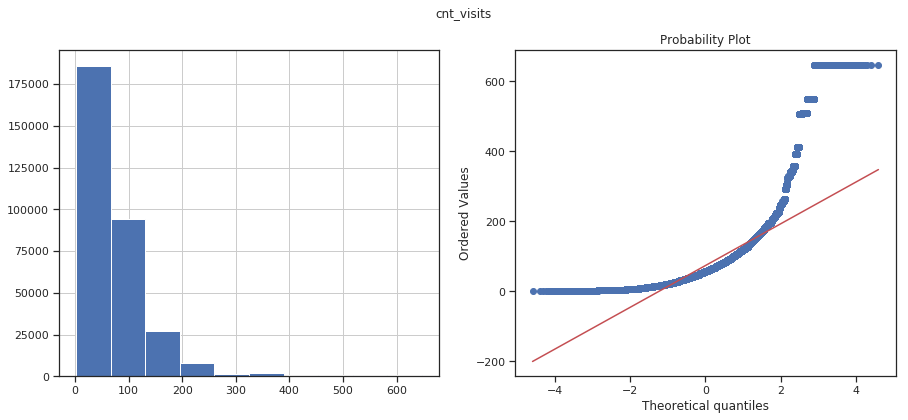

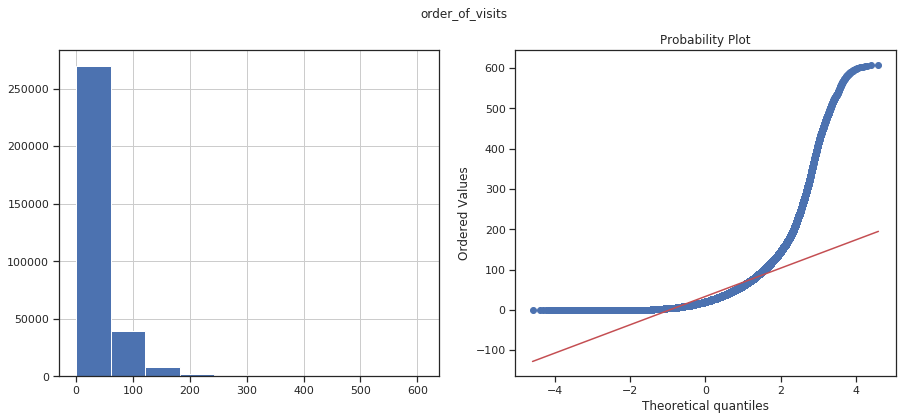

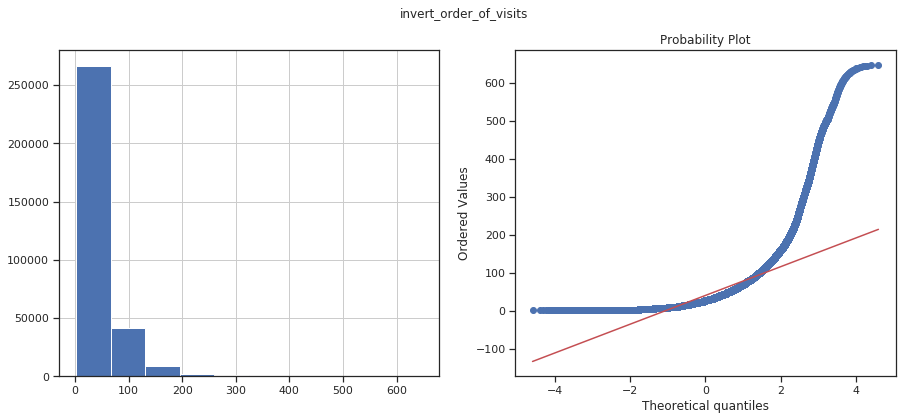

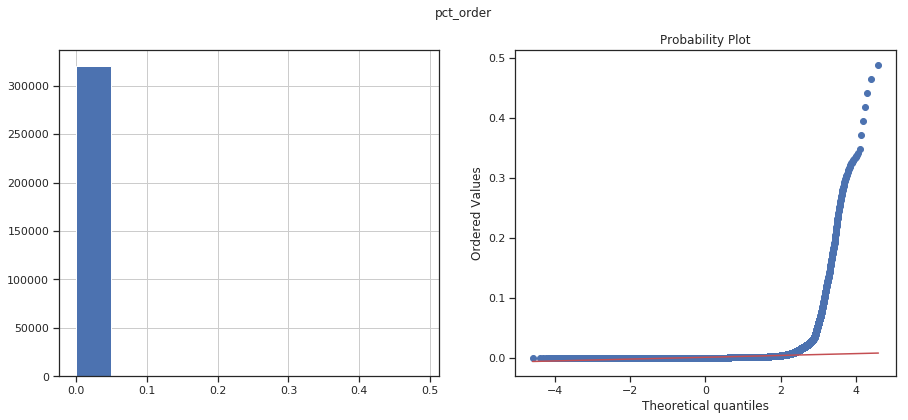

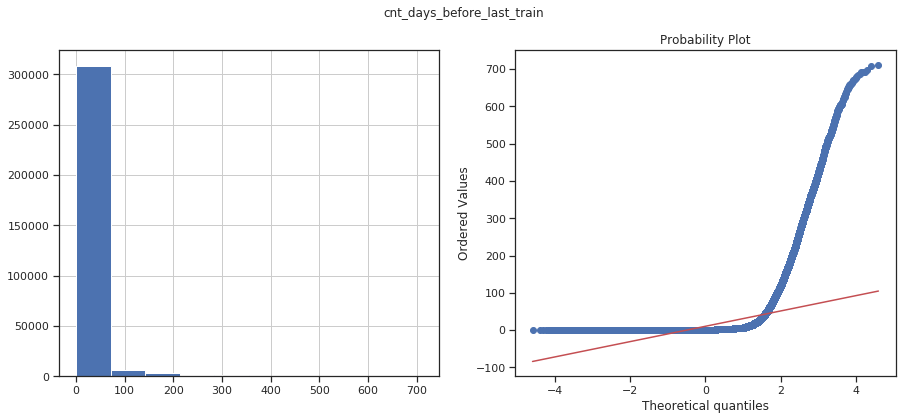

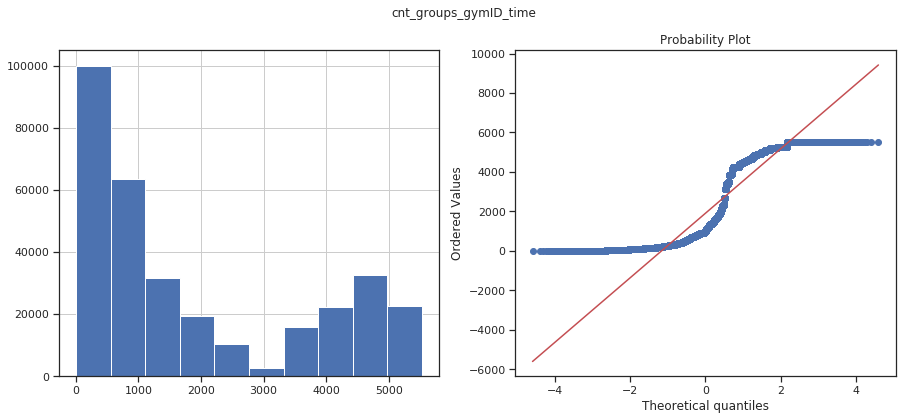

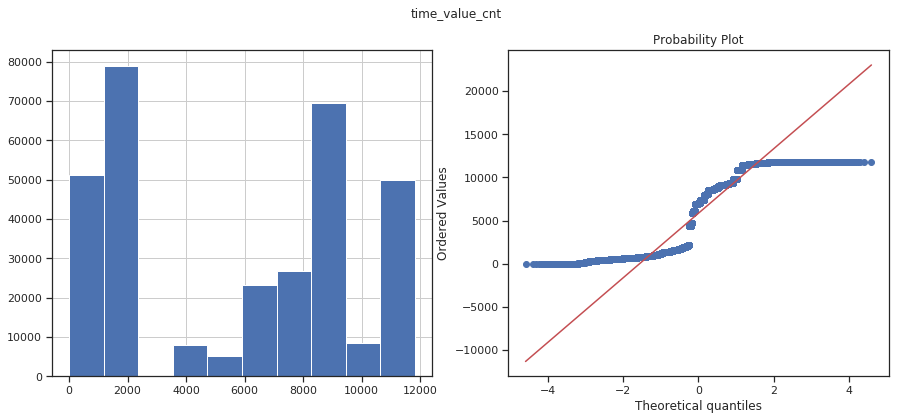

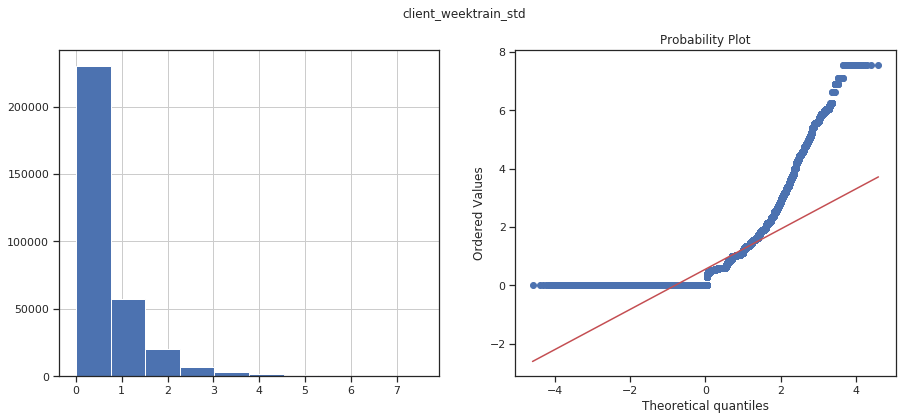

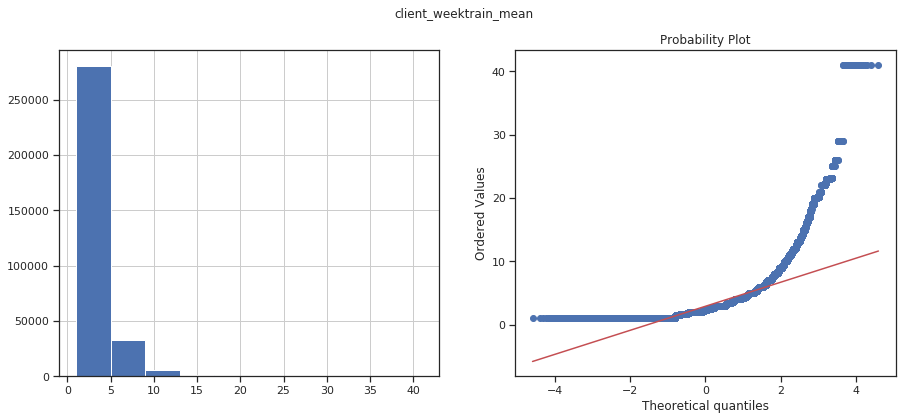

In [413]:
real_feats = train.filter(regex='(cnt|order|std|mean)').columns.tolist()

cols = [col for col in real_feats if train[col].nunique()>100]
for var in cols:
    diagnostic_plots(train, var)

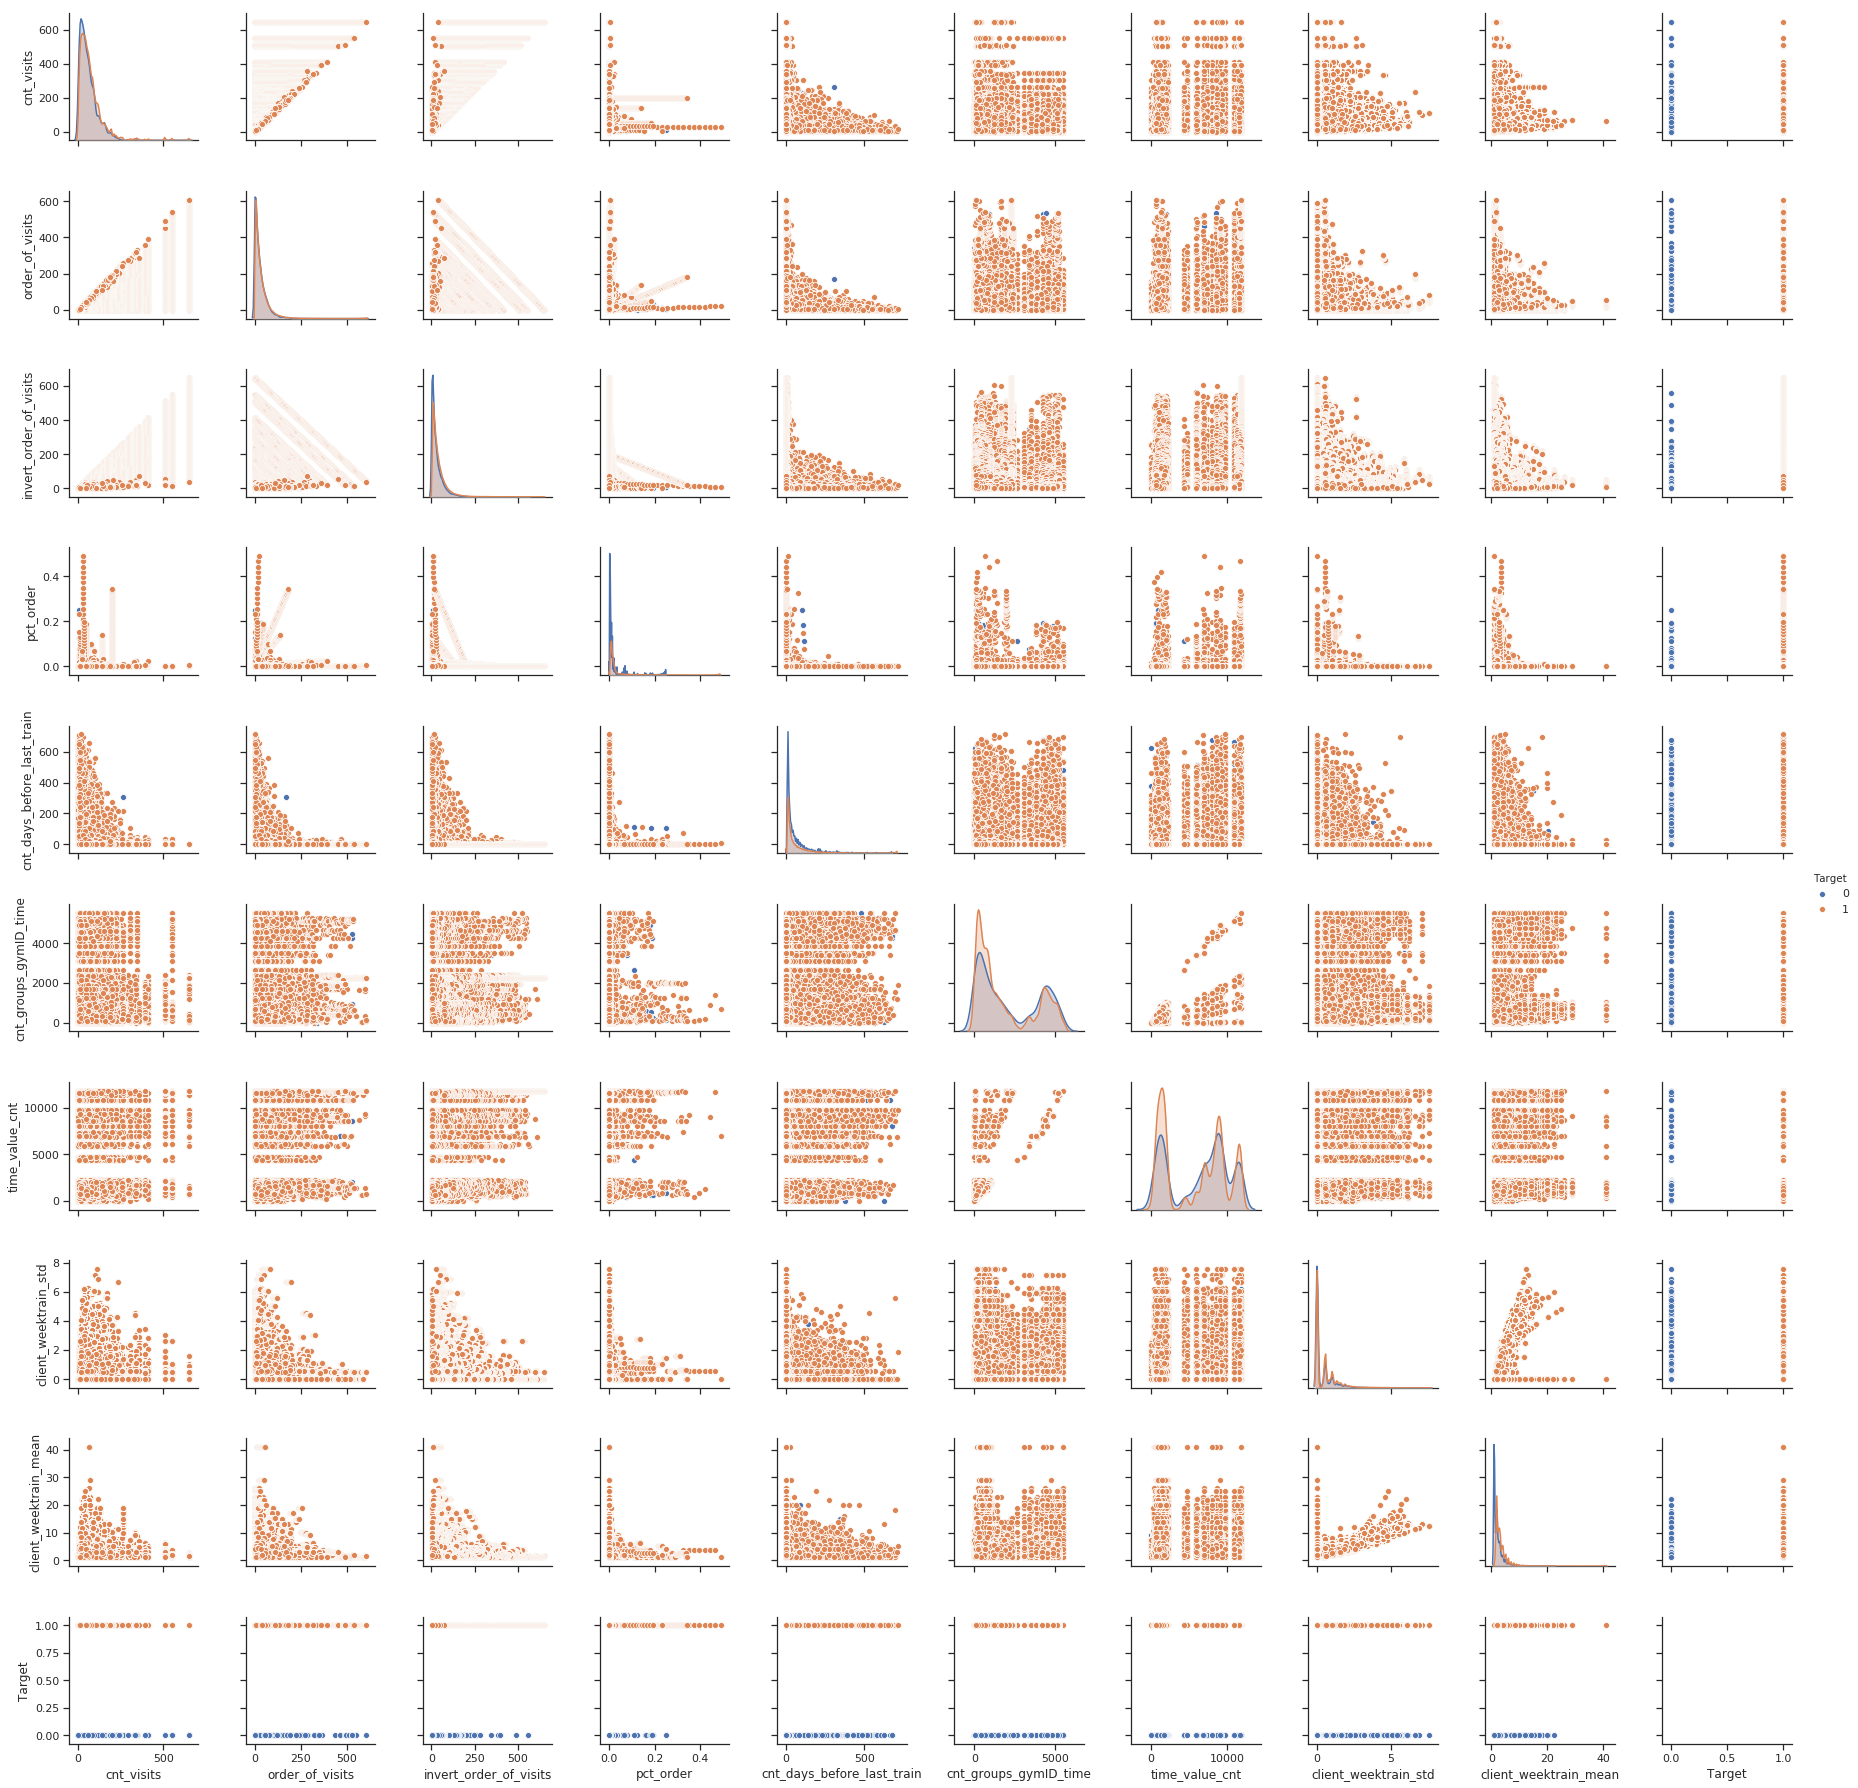

In [394]:
cols = [col for col in real_feats if train[col].nunique()>100]+["Target"]
sns.pairplot(train, vars=cols, diag_kind="kde", hue="Target")

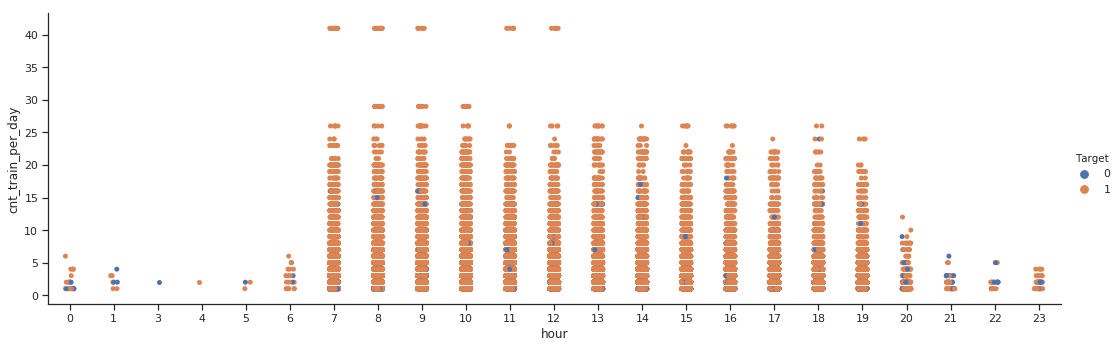

In [372]:
sns.set(style="ticks")
g = sns.catplot(x="hour", y="cnt_train_per_day", hue="Target", data=train, aspect=3);

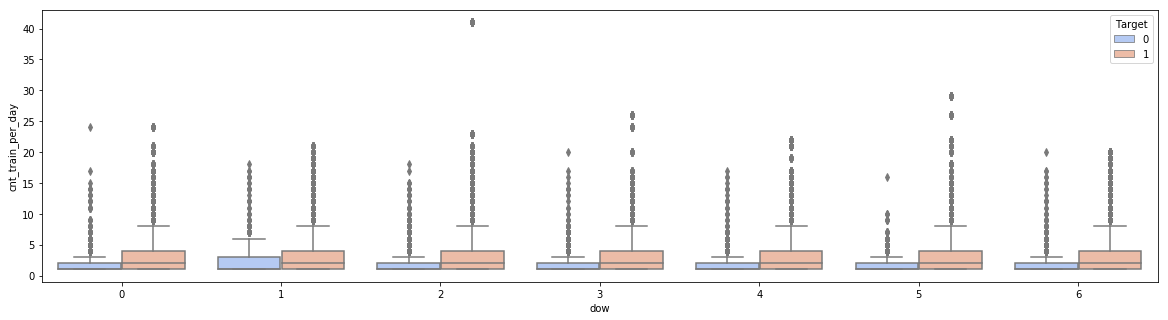

In [367]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x="dow", y="cnt_train_per_day", hue="Target", data=train, palette="coolwarm");

['cnt_visits',
 'cnt_coach_per_client',
 'cnt_traintype_per_client',
 'order_of_visits',
 'invert_order_of_visits',
 'pct_order',
 'cnt_days_before_last_train',
 'cnt_train_per_day',
 'cnt_groups_gymID_time',
 'time_value_cnt',
 'client_weektrain_std',
 'client_weektrain_mean']

In [221]:
y="Target"
Y=train[y].values
train.pop(y)

0         1
1         1
2         1
3         1
4         1
         ..
321162    1
321163    1
321164    1
321165    1
321166    1
Name: Target, Length: 321167, dtype: int16

In [291]:
# TimeSeriesSplit
tree_based_model_compare(train, Y, cv=ts, seed=SEED, score='roc_auc')

[RandomForestClassifier...] done in 44 s
[LGBMClassifier...] done in 6 s
[XGBClassifier...] done in 21 s
[CatBoostClassifier...] done in 98 s


,RF,LGB,XGB,CAT
0,0.674718,0.699737,0.713867,0.686460
1,0.767208,0.799244,0.790014,0.804674
2,0.759895,0.793597,0.772270,0.800971
,RF,LGB,XGB,CAT
count,3.000000,3.000000,3.000000,3.000000
mean,0.733940,0.764193,0.758717,0.764035
std,0.051418,0.055892,0.039842,0.067207
min,0.674718,0.699737,0.713867,0.686460
25%,0.717306,0.746667,0.743068,0.743715
50%,0.759895,0.793597,0.772270,0.800971


In [290]:
# StratifiedKFold
tree_based_model_compare(train, Y, cv=skf, seed=SEED, score='roc_auc')

[RandomForestClassifier...] done in 296 s
[LGBMClassifier...] done in 23 s
[XGBClassifier...] done in 106 s
[CatBoostClassifier...] done in 540 s


,RF,LGB,XGB,CAT
0,0.845745,0.828855,0.784651,0.840573
1,0.837666,0.822560,0.777451,0.830856
2,0.847370,0.834632,0.786318,0.840741
3,0.840514,0.830445,0.783827,0.838606
4,0.850896,0.827436,0.778635,0.836091
5,0.838345,0.825815,0.781759,0.833464
6,0.842861,0.820123,0.776696,0.831436
7,0.838177,0.822056,0.773003,0.829651
8,0.839155,0.821716,0.770429,0.823469
9,0.846400,0.822646,0.777836,0.831054


# Handling categorical features

In [622]:
# cat feats
cat_feats = train.columns.difference(real_feats + ['ClientID', 'Target']).to_list()
df_all_cats = create_partial_df_all(train, cat_feats, raw_test_df)

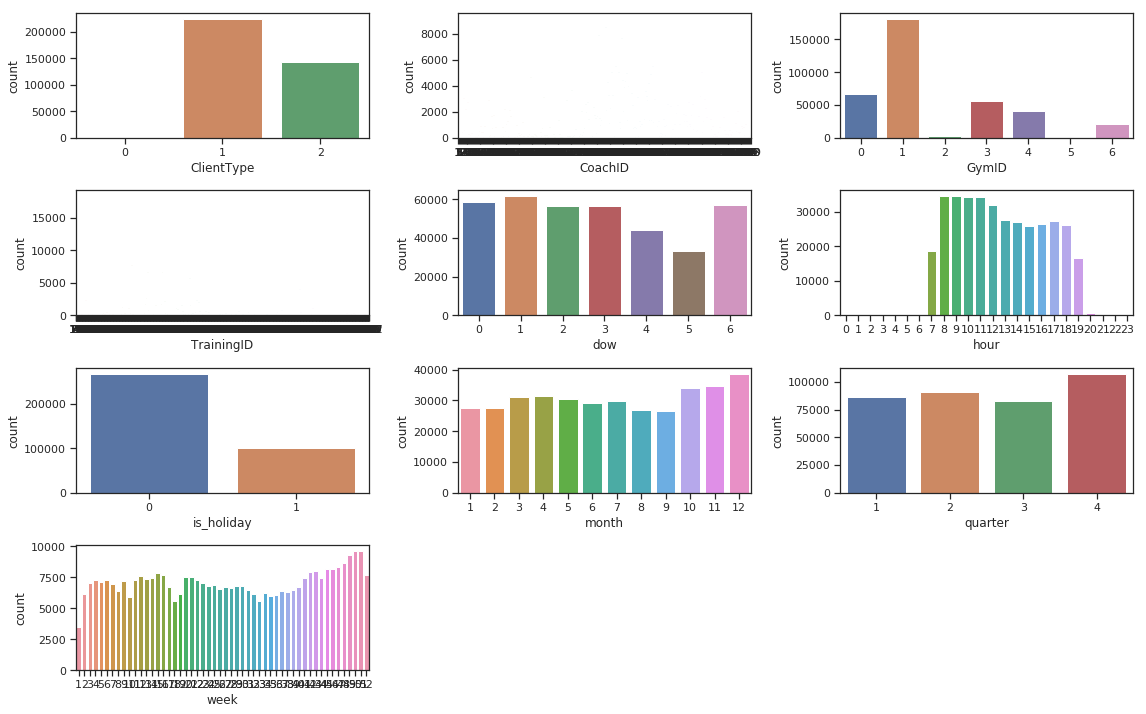

In [477]:
plt.figure(figsize=[16,10])
for i, cat in enumerate(cat_feats):
    ax = plt.subplot(4, 3, i + 1)
    sns.countplot(df_all_cats[cat], ax=ax)
    plt.grid()
    plt.tight_layout()

In [481]:
pd.crosstab(train.ClientType, train.Target, margins=True, normalize=True)

Target,0,1,All
ClientType,,,
0,0.000193,0.000277,0.000470
1,0.026220,0.572621,0.598841
2,0.013977,0.386712,0.400689
All,0.040390,0.959610,1.000000


In [623]:
df_all_cats.loc[df_all_cats["GymID"].isin([2, 5, 6]), "GymID"] = -999
df_all_cats.loc[(df_all_cats["hour"] < 7) | (df_all_cats["hour"] > 19), "hour"] = 999
df_all_cats.loc[df_all_cats["ClientType"] == 0, "ClientType"] = 1

rare_CoachID_idx = df_all_cats.CoachID.value_counts()[df_all_cats.CoachID.value_counts()<100].index.to_list()
df_all_cats.loc[df_all_cats["CoachID"].isin(rare_CoachID_idx), "CoachID"] = 999

rare_TrainingID_idx = df_all_cats.TrainingID.value_counts()[df_all_cats.TrainingID.value_counts()<100].index.to_list()
df_all_cats.loc[df_all_cats["TrainingID"].isin(rare_TrainingID_idx), "TrainingID"] = 999

cols_with_rare = ["GymID", "hour", "CoachID", "TrainingID", "ClientType"]
cols_high_cardinality = ["CoachID", "TrainingID"]

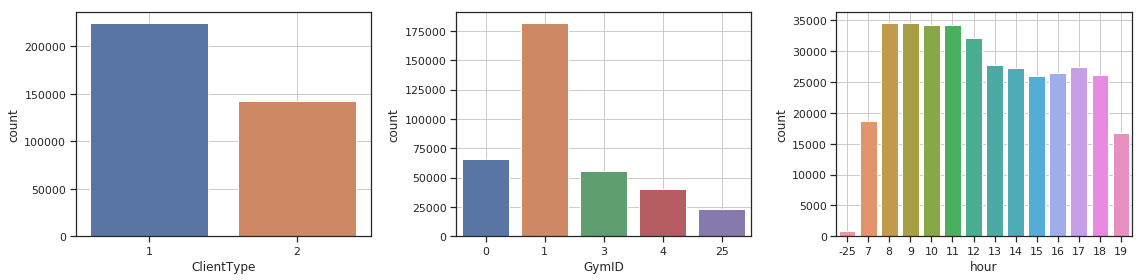

In [624]:
plt.figure(figsize=[16,4])
for i, cat in enumerate(np.setdiff1d(cols_with_rare, cols_high_cardinality)):
    ax = plt.subplot(1, 3, i + 1)
    sns.countplot(df_all_cats[cat], ax=ax)
    plt.grid()
    plt.tight_layout()

# Handling numerical features

In [634]:
df_all_numeric = create_partial_df_all(train, real_feats, raw_test_df)

In [648]:
print("Skewness")
df_all_numeric.apply(lambda x: stats.skew(x)).sort_values(ascending=False)

Skewness


pct_order                     43.816508
cnt_days_before_last_train     6.244087
invert_order_of_visits         3.936159
order_of_visits                3.936159
client_weektrain_mean          3.705320
cnt_train_per_day              3.501572
cnt_visits                     3.273439
client_weektrain_std           2.573001
cnt_gyms_per_client            1.351431
cnt_traintype_per_client       0.903766
cnt_groups_gymID_time          0.725159
cnt_coach_per_client           0.651343
cnt_ClientType_per_coach       0.419124
time_value_cnt                -0.047102
cnt_clients_per_gym           -0.111821
cnt_coaches_per_gym           -0.661666
dtype: float64

In [657]:
df_boxcox = box_cox_transform(data=df_all_numeric, num_col=None)
print("Box-cox transformation")
df_boxcox.apply(lambda x: stats.skew(x)).sort_values(ascending=False)


Skew in numerical features: 

There are 16 skewed numerical features to Box Cox transform Index(['pct_order', 'cnt_days_before_last_train', 'invert_order_of_visits',
       'order_of_visits', 'client_weektrain_mean', 'cnt_train_per_day',
       'cnt_visits', 'client_weektrain_std', 'cnt_gyms_per_client',
       'cnt_traintype_per_client', 'cnt_groups_gymID_time',
       'cnt_coach_per_client', 'cnt_ClientType_per_coach', 'time_value_cnt',
       'cnt_clients_per_gym', 'cnt_coaches_per_gym'],
      dtype='object')
Box-cox transformation


pct_order                     38.077642
cnt_days_before_last_train     1.896232
client_weektrain_std           1.306282
cnt_train_per_day              1.124763
client_weektrain_mean          1.101989
cnt_gyms_per_client            0.954740
cnt_ClientType_per_coach       0.404800
invert_order_of_visits         0.197217
order_of_visits                0.028444
cnt_visits                    -0.004356
cnt_groups_gymID_time         -0.186746
cnt_traintype_per_client      -0.428906
cnt_coach_per_client          -0.501034
time_value_cnt                -0.508756
cnt_clients_per_gym           -0.509229
cnt_coaches_per_gym           -1.966765
dtype: float64

In [651]:
df_logtransform = df_all_numeric.apply(np.log1p).copy()
print("Log-trainsformation")
df_logtransform.apply(lambda x: stats.skew(x)).sort_values(ascending=False)

Log-trainsformation


pct_order                     37.269569
cnt_days_before_last_train     1.403074
client_weektrain_std           1.170912
cnt_train_per_day              0.906569
cnt_gyms_per_client            0.901541
client_weektrain_mean          0.872069
cnt_ClientType_per_coach       0.401094
invert_order_of_visits        -0.180025
order_of_visits               -0.417737
cnt_visits                    -0.424304
cnt_groups_gymID_time         -0.573907
cnt_clients_per_gym           -0.682380
cnt_traintype_per_client      -0.698927
cnt_coach_per_client          -0.736003
time_value_cnt                -0.754197
cnt_coaches_per_gym           -2.538767
dtype: float64

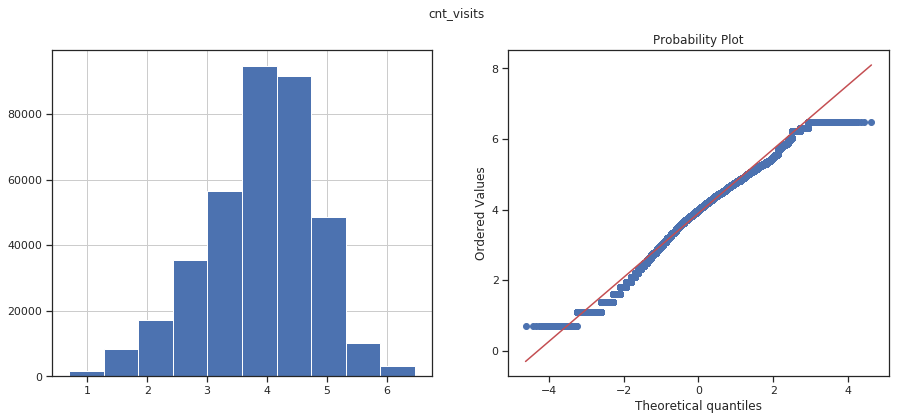

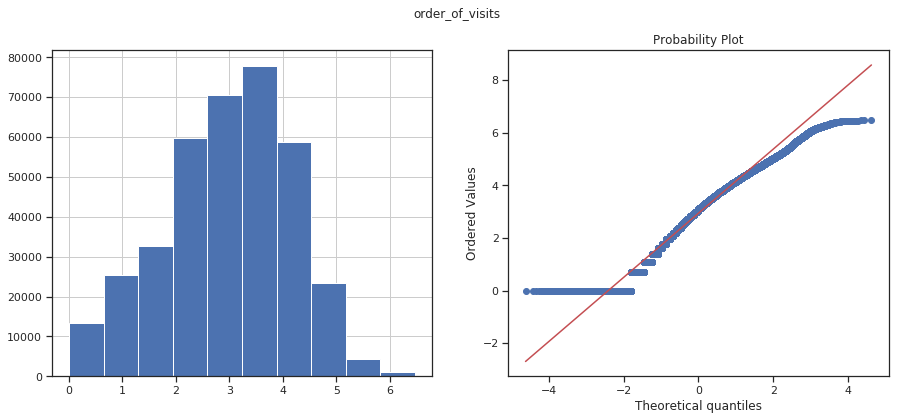

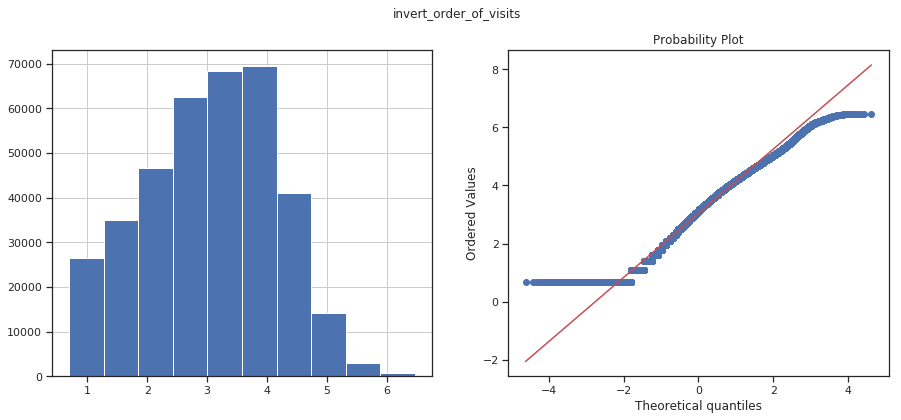

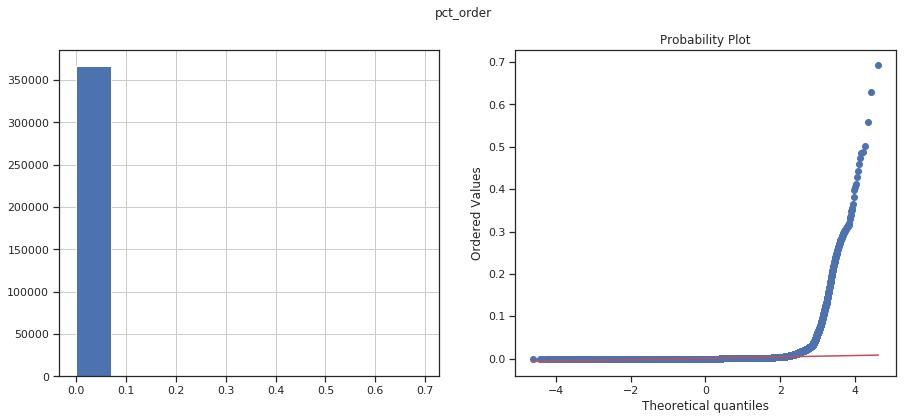

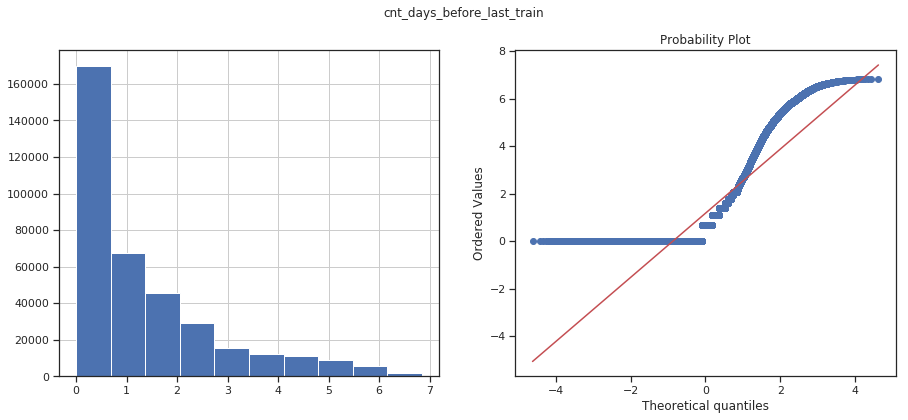

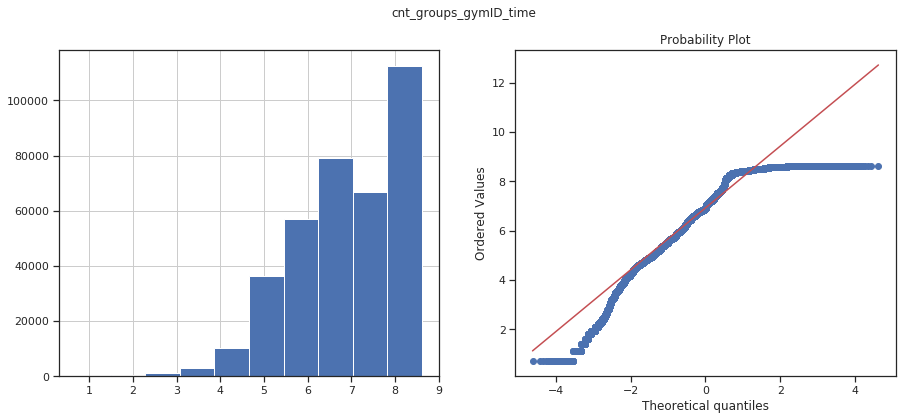

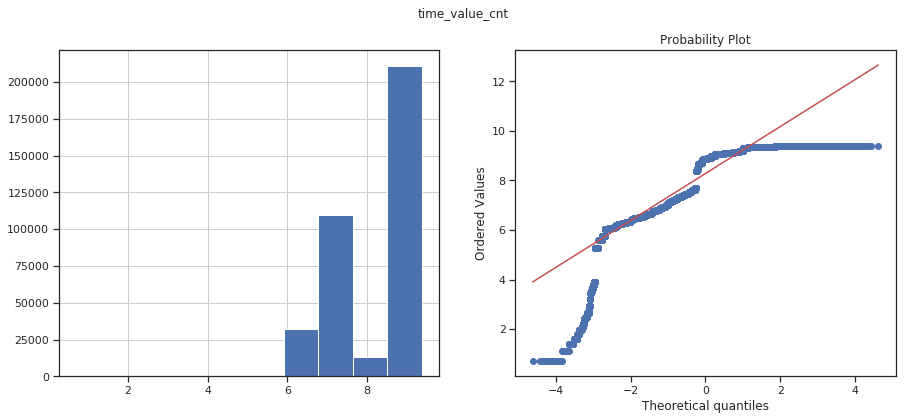

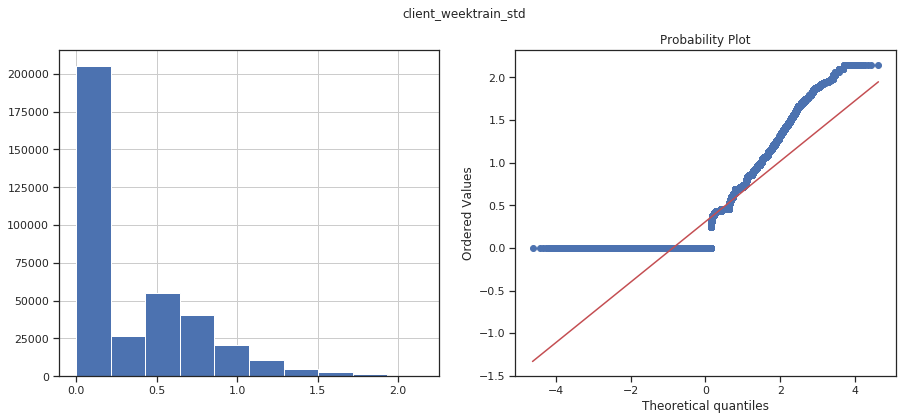

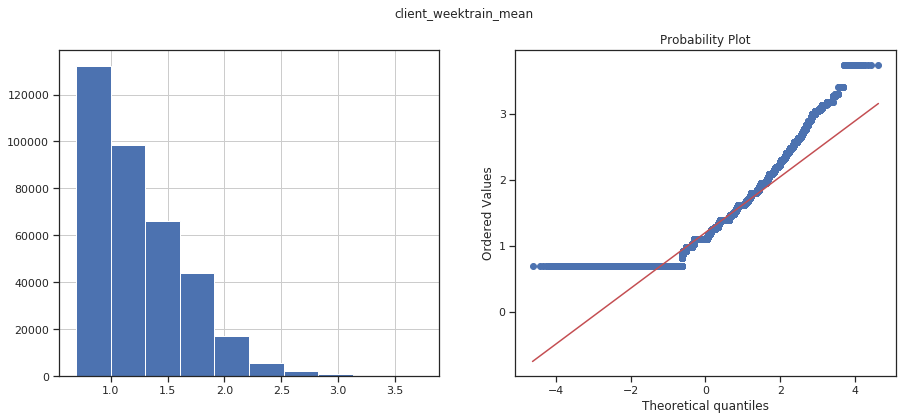

In [652]:
cols = [col for col in real_feats if train[col].nunique()>100]
for var in cols:
    diagnostic_plots(df_logtransform, var)

In [596]:
# sparse
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# [df_all_cats.columns.get_loc(c) for c in cols_to_sparse]

In [630]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(df_all_cats.astype('category')).shape

(367426, 692)

In [629]:
df_all_cats.astype('category').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367426 entries, 0 to 367425
Data columns (total 10 columns):
ClientType    367426 non-null category
CoachID       367426 non-null category
GymID         367426 non-null category
TrainingID    367426 non-null category
is_holiday    367426 non-null category
quarter       367426 non-null category
month         367426 non-null category
week          367426 non-null category
dow           367426 non-null category
hour          367426 non-null category
dtypes: category(10)
memory usage: 4.2 MB


In [665]:
df_all_cats

,ClientType,CoachID,GymID,TrainingID,is_holiday,quarter,month,week,dow,hour
0,2,495,1,847,1,1,1,52,6,8
1,2,270,3,840,1,1,1,52,6,8
2,1,523,0,1564,1,1,1,52,6,8
3,2,71,0,840,1,1,1,52,6,8
4,2,440,1,726,1,1,1,52,6,8
...,...,...,...,...,...,...,...,...,...,...
367421,1,792,25,999,0,3,9,39,4,9
367422,1,792,25,80,0,3,9,39,4,10
367423,1,770,25,999,1,3,9,39,6,12
367424,2,706,0,1423,1,3,9,39,6,17


# Feature selection

In [299]:
from boruta import BorutaPy

In [682]:
Y = train.Target.values
X = pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)].values
X.shape, len(Y)

((321167, 26), 321167)

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight={0: .75, 1: 0.25}, max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(X, y)
timer(start_time)

In [688]:
import tpot
from tpot import TPOTClassifier

In [689]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=SEED)

In [ ]:
folds   = 3
# Start the TPOT regression
best_model = TPOTClassifier(use_dask=False, n_jobs=3, config_dict=tpot_config, cv=folds, scoring='roc_auc', max_time_mins=30,
                               generations=5, population_size=10, verbosity=2, random_state=SEED) #memory='./PipelineCache',       memory='auto',
best_model.fit(X_train, Y_train)